In [217]:
import pandas as pd
import numpy as np
import os
from utils_dist_corr import *
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path_data = '/Users/alouette/Documents/Perceptual_Space_ALS/'

## Characterize geometry of perceptual space
Euclidian distance based on 2 first dimension of PCA space 

Take coordinates computed using v = all mod (all 3 modalities at the same time in the same PCA)

In [ ]:
stims = ['music','face','odor']
nb_stim = 18

for stim in stims:
    files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith('ALL_PCA.csv')]

    all_dist = np.zeros((nb_pairs(nb_stim),len(files_pca)))
    all_sub = []
    for i, f in enumerate(files_pca):
        df = pd.read_csv(path_data+'df_pca/'+ f, index_col=0)
        df_sel = df.loc[df.stimulus_type == stim]
        pairs = define_pairs(df_sel.stimulus_name)
        dist = compute_all_dist(df_sel, pairs, name_col='stimulus_name',
                           x_col='coord.Dim.1', y_col='coord.Dim.2')
        all_dist[:,i] += dist
        all_sub.append(df.subject.values[0])

    data_df = np.concatenate((np.array(pairs),all_dist),axis=1)
    df_all = pd.DataFrame(data=data_df, columns=['p0','p1']+all_sub)
    df_all.to_csv(path_data+'Python/all_dist_stim='+stim+'_v=allmod.csv')

#### Compute distances BETWEEN modality spaces (ex: all distances between odors and the rest of stimuli)

In [ ]:
files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith('ALL_PCA.csv')]

all_dist = np.zeros((972, len(files_pca)))
all_sub = []
for i, f in enumerate(files_pca):
    df = pd.read_csv(path_data+'df_pca/'+ f, index_col=0)
    df['stim_name2'] = ['O'+name if name[0] not in ('M','V') else name for name in df.stimulus_name]
    pairs = define_pairs_diff(df.stim_name2)
    dist = compute_all_dist(df, pairs, name_col='stim_name2',
                       x_col='coord.Dim.1', y_col='coord.Dim.2')
    all_dist[:,i] += dist
    all_sub.append(df.subject.values[0])

data_df = np.concatenate((np.array(pairs),all_dist),axis=1)
df_all = pd.DataFrame(data=data_df, columns=['p0','p1']+all_sub)
df_all.to_csv(path_data+'Python/all_dist_BTW_stim_v=allmod.csv')

## Compare perceptual space
Compare the consistency (R) btw space across subject for each sensory modality

### Compute perceptual spaces' consistency across subjects - WITHIN MODALITY

In [ ]:
path_df = path_data+'Python/all_dist_stim={}_v=allmod.csv'
stims = ['music','face','odor']

space_r = []
for stim in stims:
    df = pd.read_csv(path_df.format(stim), index_col=0)
    subj = [c for c in df.columns if c not in ['p0','p1']]
    pairs_su = define_pairs(subj)
    corr = compute_all_R(df, pairs_su, meth='spearman')
    space_r.append(corr) 
space_r = np.transpose(np.vstack(space_r))

df_r_var = pd.DataFrame(space_r, columns=stims)
print(df_r_var.describe())
df_r_var.to_csv(path_data+'Python/btw_subj_consistency_allstims_v=allmod.csv',index=False)

### Compute perceptual spaces' consistency across subjects - BETWEEN MODALITY

In [ ]:
path_df = path_data+'Python/all_dist_BTW_stim_v=allmod.csv'
stims_to_key = {'music':'M',
                'face': 'V',
                'odor':'O'}

df = pd.read_csv(path_df.format(stim), index_col=0)
subj = [c for c in df.columns if c not in ['p0','p1']]
pairs_su = define_pairs(subj)

space_r = []
for stim in stims_to_key:
    key = stims_to_key[stim]
    df_sel = df.loc[df['p0'].str.contains(key) | df['p1'].str.contains(key)]
    
    corr = compute_all_R(df_sel, pairs_su, meth='spearman')
    space_r.append(corr) 
space_r = np.transpose(np.vstack(space_r))
df_r_var = pd.DataFrame(space_r, columns=stims)
print(df_r_var.describe())
df_r_var.to_csv(path_data+'Python/btw_subj_consistency_BTW_stim_v=allmod.csv',index=False)

### Compare consistencies across modality (+ paired links)

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg 

df_r_var = pd.read_csv(path_data+'Python/btw_subj_consistency_BTW_stim_v=allmod.csv')

# Plot results 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
df_r_var.boxplot(column=stims, ax=axes)

# Compute 1-way repeated measures ANOVA
df_r_stats = df_r_var.melt()
df_r_stats.columns = ['stims','btw_su_corr']
df_r_stats['su_pairs'] = np.concatenate([np.arange(0,df_r_var.shape[0],1)]*3)
anova = pg.rm_anova(data=df_r_stats, dv='btw_su_corr', within='stims',
                    subject='su_pairs')
pg.print_table(anova, floatfmt='.3f')

# Bonf-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_tests(data=df_r_stats, dv='btw_su_corr', within='stims',
                            subject='su_pairs', padjust='bonf')
pg.print_table(posthoc, floatfmt='.3f')

# Pairwise correlations between sensory modality
pair_r = pg.pairwise_corr(df_r_var, method='pearson')
print(pair_r)

### Compare perceptual spaces' size and dispersion v=bymod

In [ ]:
stims = ['music','face','odor']
cols_to_sel = ['%var_cum','pol_surf','circ_surf','avg_d']

files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith('_PCA_sum.csv')]
    
all_pca = np.zeros((len(files_pca),4))
infos = np.array([])
for i,f in enumerate(files_pca):
    splits = [sp.split('_') for sp in f.split('=')]
    s_splits = np.array((splits[1][0],splits[2][0]))
    infos = np.vstack((infos,s_splits)) if np.size(infos) else np.array(s_splits)
    
    df = pd.read_csv(path_data+'df_pca/'+f, index_col=0)
    df.columns = ['cos2','%var','%var_cum','pol_surf','circ_surf','x0','y0','avg_d']
    sel = df[cols_to_sel].loc[['comp 2']].values[0]
    all_pca[i,:] += sel

data_df = np.concatenate((infos,all_pca), axis=1)
df_all = pd.DataFrame(data=data_df, columns=['subject','stim']+cols_to_sel)
print(df_all)
df_all.to_csv(path_data+'Python/all_spaces_geometry.csv',index=False)

### Compare perceptual spaces' size and dispersion v=allmod
Average distance and circle surface NOT included

In [ ]:
files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith('ALL_PCA_sum.csv')]
    
all_pca = np.zeros((len(files_pca),3))
infos = np.array([])
for i,f in enumerate(files_pca):
    splits = [sp.split('_') for sp in f.split('=')]
    s_splits = np.array((splits[1][0]))
    infos = np.vstack((infos,s_splits)) if np.size(infos) else np.array(s_splits)
    
    df = pd.read_csv(path_data+'df_pca/'+f, index_col=0)
    cols_to_sel = [c for c in df.columns if 'surf' in c]
    sel = df[cols_to_sel].loc[['comp 2']].values[0]
    all_pca[i,:] += sel

data_df = np.concatenate((infos,all_pca), axis=1)
df_all = pd.DataFrame(data=data_df, columns=['subject']+cols_to_sel)
df_all.to_csv(path_data+'Python/all_spaces_geometry_v=allmod.csv',index=False)

### Statistics and plots - spaces geometry 

In [ ]:
import pingouin as pg 
v = 'allmod'

df_geo0 = pd.read_csv(path_data+'Python/all_spaces_geometry_v=allmod.csv')
if v == 'allmod':
    df_geo = df_geo0.iloc[:,1:].melt()
    df_geo['subjects'] = list(df_geo0['subject'].values)*3

    # Plot results 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    print('>> effect of surf ALL mod ')
    df_geo[['value','variable']].boxplot(ax=axes, by='variable')
    print(df_geo)
    anova = pg.rm_anova(data=df_geo, dv='value', within='variable',
                    subject='subjects')
    pg.print_table(anova, floatfmt='.3f')

    if anova.iloc[0,4] < 0.05:
        # Bonf-corrected post hocs with Hedges'g effect size
        posthoc = pg.pairwise_tests(data=df_geo, dv='value', within='variable',
                            subject='subjects', padjust='bonf')
        pg.print_table(posthoc, floatfmt='.3f')
    

else:
    # Plot results 
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
    for i,c in enumerate(df_geo.columns[2:]):
        print('>> effect of modality on ',c)
        df_geo[[c,'stim']].boxplot(ax=axes[i], by='stim')
        anova = pg.rm_anova(data=df_geo, dv=c, within='stim',
                        subject='subject')
        pg.print_table(anova, floatfmt='.3f')

        if anova.iloc[0,4] < 0.05:
            # Bonf-corrected post hocs with Hedges'g effect size
            posthoc = pg.pairwise_tests(data=df_geo, dv=c, within='stim',
                                subject='subject', padjust='bonf')
            pg.print_table(posthoc, floatfmt='.3f')
    

### Correlation btw perceptual spaces' size and memory v=allmod
d' recognition performance and episodic memory performance

In [25]:
path_mem = '/Users/alouette/Documents/Perceptual_Space_ALS/old/'
stims = ['all','odor','music','face']

#load space geometry 
df_geo = pd.read_csv(path_data+'Python/all_spaces_geometry_v=allmod.csv')
df_geo['surf poly all'] = df_geo.iloc[:,1:].mean(axis=1)
df_geo = df_geo.sort_values(['subject'])
df_geo.columns = ['subject', 'surf poly odor', 'surf poly face', 
                  'surf poly music','surf poly all']

#load df memory perf (select subjects)
df_ret = pd.read_excel(path_mem+'all_rappel_score.xls')
df_ret = df_ret.loc[df_ret['subject'].isin(subjects_no_out)]

for stim in stims:
    
    #recognition performance
    if stim =='all':
        df_stim = df_ret
    else:
        df_stim = df_ret[~df_ret[stim].isna()]
    
    df_gr = df_ret.groupby(['subject','score_recognition']).count()['trial_num']
    df_gr = df_gr.unstack().fillna(0) #replace NaN values by 0
    HR = (df_gr['hit'] + 0.5) / (27 + 1)
    FR = (df_gr['fa'] + 0.5) / (27 + 1)
    df_gr['d_prime'] = np.log((HR* (1 - FR))/(FR * (1 - HR)))
    print('2 df in the same order => ', any(df_geo.subject == df_gr.index))

    df_tot = df_geo.merge(df_gr, left_on='subject', right_on='subject')
    pair_allmod = pg.pairwise_corr(df_tot[['d_prime','surf poly '+stim]], method='pearson')
    print('REC correl for ',stim, pair_allmod)

    #global episodic performance
    df_gr2 = df_ret.groupby(['subject','episodic_score']).count()['trial_num']
    df_gr2 = df_gr2.unstack().fillna(0) #replace NaN values by 0
    df_gr2['WWW-R'] = (df_gr2['www'] + 0.5) / (27 + 1)
    df_gr2['W-R'] = (df_gr2['w'] + 0.5) / (27 + 1)
    print('2 df in the same order => ', any(df_geo.subject == df_gr2.index))
    
    df_tot2 = df_geo.merge(df_gr2, left_on='subject', right_on='subject')
    pair_allmod2 = pg.pairwise_corr(df_tot2[['WWW-R','W-R','surf poly '+stim]],method='pearson')
    if any(pair_allmod2['p-unc']<0.05):
        print('EPI correl for ',stim, pair_allmod2)

2 df in the same order =>  True
REC correl for  all          X              Y   method alternative   n         r          CI95%  \
0  d_prime  surf poly all  pearson   two-sided  48 -0.097134  [-0.37, 0.19]   

      p-unc   BF10    power  
0  0.511324  0.222  0.10078  
2 df in the same order =>  True
EPI correl for  all        X              Y   method alternative   n         r          CI95%  \
0  WWW-R            W-R  pearson   two-sided  48 -0.660308  [-0.8, -0.46]   
1  WWW-R  surf poly all  pearson   two-sided  48 -0.099611  [-0.37, 0.19]   
2    W-R  surf poly all  pearson   two-sided  48  0.108715  [-0.18, 0.38]   

          p-unc       BF10     power  
0  3.286469e-07  5.556e+04  0.999671  
1  5.005590e-01      0.224  0.103498  
2  4.620188e-01      0.234  0.114134  
2 df in the same order =>  True
REC correl for  odor          X               Y   method alternative   n         r          CI95%  \
0  d_prime  surf poly odor  pearson   two-sided  48 -0.028459  [-0.31, 0.26]   

### Explore dist between distactors and targets and its impact on memory performance
For ALL sensory modalities together

In [66]:
def pairs_btw_groups(gr1, gr2):
    pairs = [(p0, p1) for p0, p1 in product(gr1,gr2)]
    return pairs

In [231]:
stims = ['all','face','odor','music']
files_pca = [f for f in os.listdir(path_data + 'df_pca/') if f.endswith('ALL_PCA.csv')]

for stim in stims:
    all_d, all_s = np.zeros((len(files_pca),3)), []
    for i,f in enumerate(files_pca):
        #perceptual space coordinates
        df_pca = pd.read_csv(path_data+'df_pca/'+ f, index_col=0)
        su = np.unique(df_pca['subject'])[0]

        #stimuli config by subject
        df_mem = pd.read_excel(path_data+'old/all_rappel_score.xls',index_col=0)
        cols = ['subject','face','odor','music','score_recognition','episodic_score']
        conf_su = df_mem[cols].loc[df_mem['subject']==su].reset_index().iloc[:,1:]
        conf_su = conf_su.fillna('')
        conf_su = conf_su.astype(str)
        conf_su['odor'] = [r.split('.')[0] for r in conf_su['odor']]
        conf_su['stimulus_name'] = conf_su["face"] + conf_su["odor"] + conf_su['music']
        conf_su['type'] = [c if c == 'distractor' else 'target' for c in conf_su['episodic_score']]
        dict_su = conf_su[['stimulus_name','type']].set_index('stimulus_name').T.to_dict('list')

        #add stimuli type in pca files
        df_pca['type'] = df_pca['stimulus_name'].map(dict_su)

        #find and remove index with Nan values (S08 & S14)
        nan_idx = df_pca['type'].isna()
        df_pca = df_pca.drop(nan_idx[nan_idx].index.values)
        #reformat the type column
        df_pca['type'] = [x[0] for x in df_pca['type']]
        
        #get the two groups to compare
        if stim != 'all':
            df_pca = df_pca.loc[df_pca['stimulus_type']==stim]
        
        gr1 = df_pca.loc[df_pca['type']=='target']
        gr2 = df_pca.loc[df_pca['type']=='distractor']
        pairs = pairs_btw_groups(gr1=gr1.stimulus_name, gr2=gr2.stimulus_name)
        distances = compute_all_dist(df_pca, pairs, name_col='stimulus_name',
                           x_col='coord.Dim.1', y_col='coord.Dim.2')
        all_d[i,0] += np.mean(distances)
        all_d[i,1] += np.median(distances)
        all_d[i,2] += np.max(distances)
        all_s.append(su)

    data = np.concatenate((np.array(all_s)[:,np.newaxis],all_d),axis=1)
    df_save = pd.DataFrame(data=data, columns=['subjects','mean d', 'median d', 'max d'])
    df_save.to_csv(path_data+'Python/df_distances_target_foils_stim={}.csv'.format(stim),index=False)

### Correlations btw perf and target-foil distances
All modalities together

>> processing pair correlations for all d_prime
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processing pair correlations for all HR
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processing pair correlations for all FR
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processing pair correlations for all WWW-R
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processing pair correlations for all W-R
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processing pair correlations for face d_prime
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processing pair correlations for face HR
Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []
>> processi

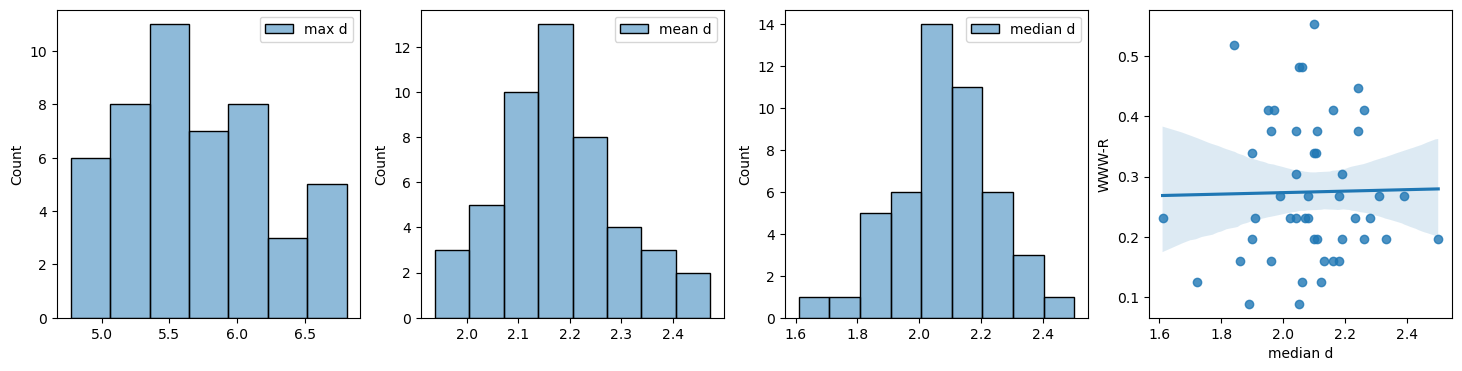

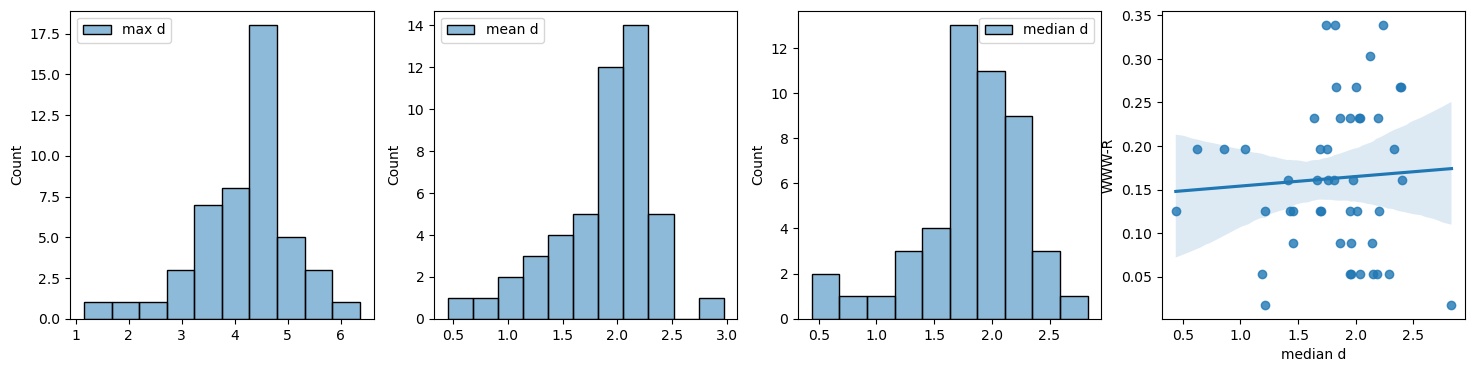

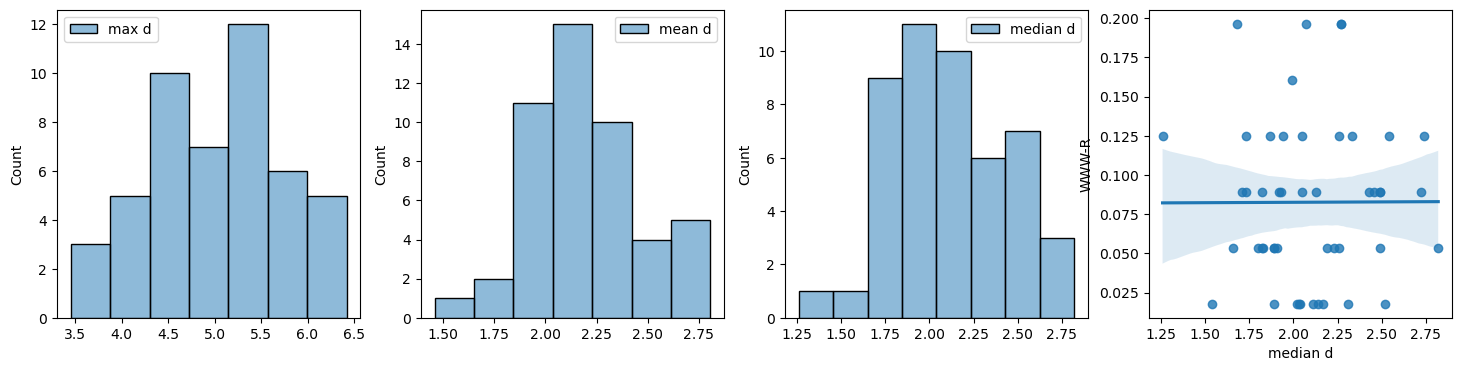

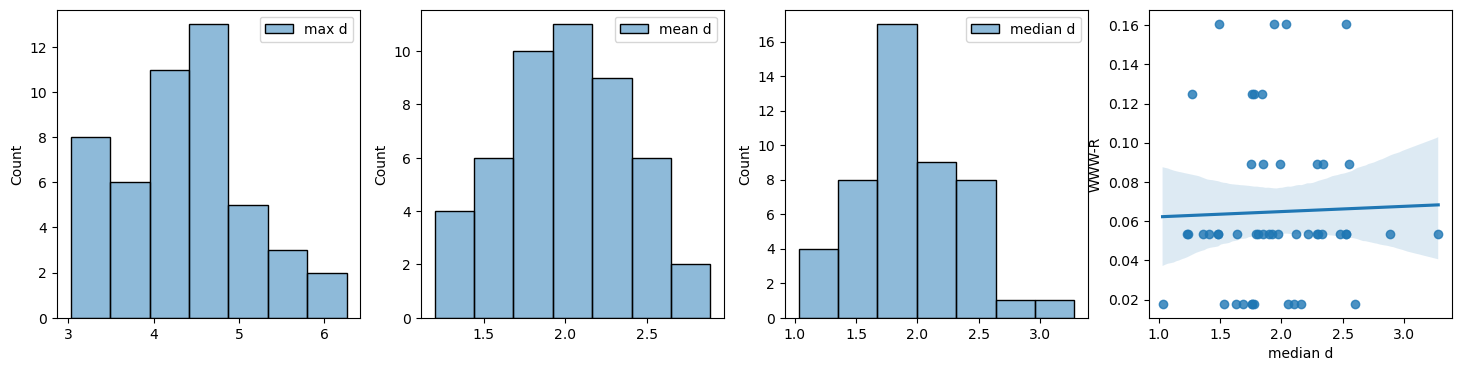

In [239]:
stims = ['all','face','odor','music']

for stim in stims:
    df_dist = pd.read_csv(path_data+'Python/df_distances_target_foils_stim={}.csv'.format(stim),index_col=0)
    df_dist = df_dist.sort_values(['subjects'])

    #histograms of distances
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
    sns.histplot(data=df_dist[['max d']], ax=axes[0])
    sns.histplot(data=df_dist[['mean d']], ax=axes[1])
    sns.histplot(data=df_dist[['median d']], ax=axes[2])
    
    #select perf by sensory modality
    if stim != 'all':
        df_rec = pd.read_csv(path_data+'Python/rec_perf_allsubjects_stim={}.csv'.format(stim))
        df_epi = pd.read_csv(path_data+'Python/epi_perf_allsubjects_stim={}.csv'.format(stim))
    else:
        df_rec = pd.read_csv(path_data+'Python/rec_perf_allsubjects.csv')
        df_epi = pd.read_csv(path_data+'Python/epi_perf_allsubjects.csv')
        
    #print('df in the same order EPI & DIST => ', any(df_dist.index == df_rec.subjects))
    df_perf = df_rec.merge(df_epi)[['d_prime','HR','FR','WWW-R','W-R']]

    for c in df_perf.columns:
        print('>> processing pair correlations for', stim, c)
        df_corr = df_dist.assign(c=df_perf[c].values)
        pair_corr = pg.pairwise_corr(df_corr, method='pearson')
        print_pair = pair_corr.loc[(pair_corr['X']=='c') | (pair_corr['Y']=='c')]
        print(print_pair.loc[print_pair['p-unc']<0.05])

    sns.regplot(x=df_dist[['median d']], y=df_epi[['WWW-R']],ax=axes[3]);